# Project 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from random import random, seed

In [2]:
from RegressionMethod import RegressionMethod, RegressionType
from SamplingMethod import SamplingMethod
from HelperFunctions import *
from BootstrapSampling import BootstrapSampling
#from CrossValidationKFold import CrossValidationKFold

In [3]:
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

In [23]:
seed = 2020
np.random.seed(seed)
# Make data.
x0 = np.arange(0, 1, 0.05)
y0 = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x0,y0)

z = FrankeFunction(x, y)

In [ ]:
# x0, y0, z0 = create_frankie_data(seed, N = N, noise_strength=0.0)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x0, y0, z0, c='skyblue', s=5)
# ax.scatter(x, y, z, c='red', s=5)
# #ax.view_init(30, 185)
# plt.show()

### Part a): Ordinary Least Square (OLS) on the Franke function
- [ ] Fix your x and y values, they should span the whole room. Using linspace and mesh
- [ ] Add confidence intervals for beta by computing variance for each beta

### a) OLS on the Franke function
Show confidence_interval

In [4]:
N = 100
noise = 0.0
x, y, z = create_frankie_data(seed, N = N, noise_strength=noise)
X = create_X(x, y, n = 2)
sampling = SamplingMethod().train_and_test(X, z, RegressionType.OLS)
#confidence_interval(X, z, sampling.model.beta, noise, N, save_fig = True)

Y_pred shape:  (2000, 1)


### Part b): Bias-variance trade-off and resamplng techniques

- [ ] Implement bootstraping, it should get data several times for each polynomial. Just to have a better estimate of errors and such. Not to to train better

In [43]:
N = 50
noise = 0.3
p = 5

x, y, z = create_frankie_data(seed, N = N, noise_strength=noise)
polydegree = np.zeros(p); mse_train = np.zeros(p); mse_test = np.zeros(p); 

for degree in range(p):
    polydegree[degree] = degree

    X = create_X(x, y, degree, debug = False)
    sampling = SamplingMethod().train_and_test(X, z, RegressionType.OLS)
    mse_test[degree] = sampling.mse

    mse_train[degree] = sampling.test_model(sampling.model, sampling.X_train, sampling.y_train).mse


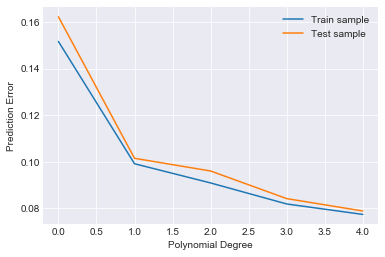

In [44]:
values_to_plot = {
    "Train": mse_train,
    "Test": mse_test,
}

plot_test_train_model_complexity(polydegree, values_to_plot, N, save_fig = False)

In [21]:
N = 55
noise = 0.0
p = 6
trials = 100
sample_count = N
polydegree = np.zeros(p); r2_boot = np.zeros(p); mse_boot = np.zeros(p); bias_boot = np.zeros(p); var_boot = np.zeros(p)
x, y, z = create_frankie_data(seed, N,  noise_strength=noise)

for degree in range(p):
    polydegree[degree] = degree + 1

    X = create_X(x, y, degree, debug = False)
    boot = BootstrapSampling(trials, sample_count).train_and_test(X, z, RegressionType.OLS)
    r2_boot[degree] = boot.r2; mse_boot[degree] = boot.mse; bias_boot[degree] = boot.bias; var_boot[degree] = boot.var; 

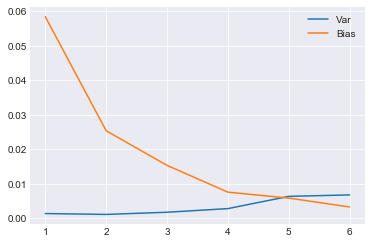

In [22]:
values_to_plot = {
    "Var": var_boot,
    "Bias": bias_boot,
}

plot_test_train(polydegree, values_to_plot)

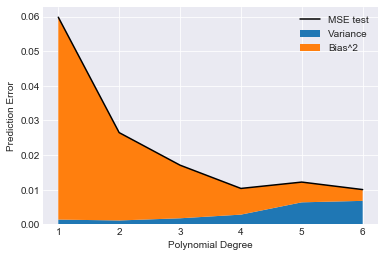

In [24]:
def plot_bias_variance_analysis(polydegree, values_to_plot, N = -1, trials = -1, sample_count = -1, noise_strength = 0.1, save_fig = False):
    plt.style.use('seaborn-darkgrid')
    y1 = values_to_plot["variance"]
    y2 = values_to_plot["bias"]
    y = np.vstack([y1, y2])
    labels = ["Variance", "Bias^2"]
    fig, ax = plt.subplots()

    plt.xlabel("Polynomial Degree")
    plt.ylabel("Prediction Error")
    ax.stackplot(polydegree, y1, y2, labels=labels)
    ax.plot(polydegree, values_to_plot["mse"], color="black", label = "MSE test")
    ax.legend(loc='upper right')
    if(N != -1 and trials != -1 and sample_count != -1):
        plt.figtext(0.1, -0.1, "Noise Strength: " + str(noise_strength) + "\nNumber of samples: " + str(N) + "\nTrials: " + str(trials) + "\nBoostrap samples: " + str(sample_count), ha="left", fontsize=7)
    if save_fig:
        save_figure("TestTrainErrorAsModelComplexity" + str(N) + str(trials) + str(sample_count) + str(noise_strength).replace(".", ""))
    plt.show()

values_to_plot = {
    "variance": var_boot,
    "mse": mse_boot,
    "bias": bias_boot,
}

plot_bias_variance_analysis(polydegree, values_to_plot)

array([0.05818926, 0.0582581 , 0.05869788, 0.05848413, 0.05840973,
       0.05841429, 0.05824649, 0.05906734])

### c): Cross-validation

In [8]:
k_folds = 5
p = 12
N = 100
polydegree = np.zeros(p)

train_results_cross_valid = RegressionResults(p)
test_results_cross_valid = RegressionResults(p)
x, y, z = create_frankie_data(seed, N)
for degree in range(p):
    polydegree[degree] = degree

    X = create_X(x, y, degree, debug = False)
    cross_valid = CrossValidationKFold(X, z, RegressionMethod(), k_folds)
    train_deg_result, test_deg_result = cross_valid.fit()
    train_results_cross_valid.set_results(train_deg_result, degree)
    test_results_cross_valid.set_results(test_deg_result, degree)

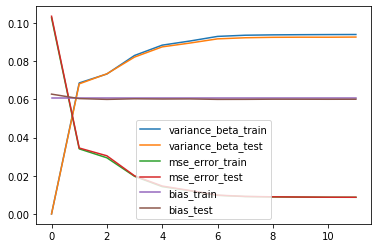

In [10]:
values_to_plot = {
    "variance_beta_train": train_results_cross_valid.variance_beta_avg,
    "variance_beta_test": test_results_cross_valid.variance_beta_avg,
    "mse_error_train": train_results_cross_valid.mse_avg,
    "mse_error_test": test_results_cross_valid.mse_avg,
    "bias_train": train_results_cross_valid.bias_avg,
    "bias_test": test_results_cross_valid.bias_avg,
}


plot_test_train(polydegree, values_to_plot)

### Part d): Ridge Regression on the Franke function  with resampling

1. Implement Ridge Regression
2. Preform bootstrap analysis as in b)
3. Preform cross-validation as in c) but now on dependence on $\lambda$
4. Comment on the differences

- [ ] Compute beta using s v d
- [ ] Implement your own svd ?

In [4]:
trials = 5
sample_count = 1000
p = 4
N = 1000
polydegree = np.zeros(p)

train_results = RegressionResults(p)
test_results = RegressionResults(p)
x, y, z = create_frankie_data(seed, N)
for degree in range(p):
    print("Bootstrap: ", degree + 1)
    polydegree[degree] = degree

    X = create_X(x, y, degree, debug = False)
    boot = BootstrapSampling(X, z, RegressionMethod(ModelType.Ridge), trials, sample_count)
    train_deg_result, test_deg_result = boot.fit()
    train_results.set_results(train_deg_result, degree)
    test_results.set_results(test_deg_result, degree)

Bootstrap:  1
Bootstrap:  2
Bootstrap:  3
Bootstrap:  4


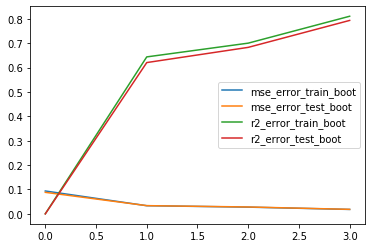

In [5]:
values_to_plot = {
    "mse_error_train_boot": train_results.mse_avg,
    "mse_error_test_boot": test_results.mse_avg,
    "r2_error_train_boot": train_results.r2_avg,
    "r2_error_test_boot": test_results.r2_avg,
}

plot_test_train(polydegree, values_to_plot)

0  lambda:  0.0
1  lambda:  0.1
2  lambda:  1.0
3  lambda:  100.0
4  lambda:  1000.0
5  lambda:  1000000.0


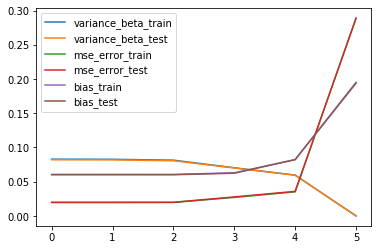

In [6]:
k_folds = 5
p = 3
N = 100
lambda_values = np.array([0.0, 0.1, 1.0, 100.0, 1000.0, 1000000.0])
train_results_cross_valid = RegressionResults(len(lambda_values))
test_results_cross_valid = RegressionResults(len(lambda_values))
x, y, z = create_frankie_data(seed, N)
X = create_X(x, y, p, debug = False)

for i in range(len(lambda_values)):
    print(i, " lambda: ", lambda_values[i])
    cross_valid = CrossValidationKFold(X, z, RegressionMethod(ModelType.Ridge, alpha = lambda_values[i]), k_folds)
    train_deg_result, test_deg_result = cross_valid.fit()
    train_results_cross_valid.set_results(train_deg_result, i)
    test_results_cross_valid.set_results(test_deg_result, i)

values_to_plot = {
    "variance_beta_train": train_results_cross_valid.variance_beta_avg,
    "variance_beta_test": test_results_cross_valid.variance_beta_avg,
    "mse_error_train": train_results_cross_valid.mse_avg,
    "mse_error_test": test_results_cross_valid.mse_avg,
    "bias_train": train_results_cross_valid.bias_avg,
    "bias_test": test_results_cross_valid.bias_avg,
}

plot_test_train([x for x in range(len(lambda_values))], values_to_plot)

### Terrain Data

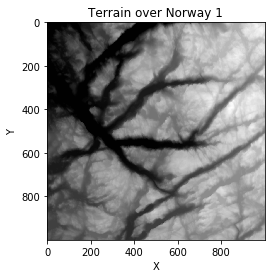

In [13]:
x_mesh, y_mesh, z = create_terrain_data(N = 1000, path = 'DataFiles/SRTM_data_Norway_2.tif')
p = 2
X = create_X(x_mesh, y_mesh, p)

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(z, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

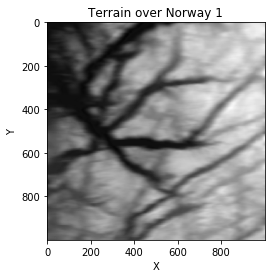

In [44]:
from scipy.signal import savgol_filter
smoothed_z = savgol_filter(z, 77, 2)
#plot_3d_graph(x_mesh, y_mesh, z, "Norway Terrain Data", "Elevation of terrain", dpi=150, formatter='%.f',z_line_ticks=6, view_azim=-50, set_limit=False, save_fig=True)
#plot_3d_graph(x_mesh, y_mesh, smoothed_z, "Norway Terrain Data Smoothed (Savgol filter)", "Elevation of terrain", dpi=100, formatter='%.f',z_line_ticks=6, view_azim=-50, set_limit=False, save_fig=True)
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(smoothed_z, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()